# Note to user :
This version is a cleaner and faster version of https://www.kaggle.com/code/martinijean/csiro-img2bio-eda-xgboost-pca-image-f-9e66b7
What I added/Deleted :
- Deleted : EDA, messy cell, redundancy
- Added : importing/exporting dataset, flexible choice of number of streams and tiles, KFolding on 5 MLP to features, KFolding on XGBoost to 5 target, overfit analysis (score on train vs val)
# [1/5] Load Data

In [1]:

# !pip download -d packages transformers
!pip install -q -U transformers --no-index -f /kaggle/input/metadino-v3-convnext/pytorch/default/3/packages
import huggingface_hub

import os
import glob
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import time

import torch
import warnings

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
import kagglehub

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold,train_test_split,KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import numpy as np



# Download latest version
path1 = kagglehub.model_download("metaresearch/dinov2/pyTorch/small")
path2 = kagglehub.model_download("metaresearch/dinov2/pyTorch/base")
path3 = kagglehub.model_download("metaresearch/dinov2/pyTorch/large")
path4 = kagglehub.model_download("metaresearch/dinov2/pyTorch/giant")
print("4 versions of Dino V2 operationals")

warnings.simplefilter(action='ignore', category=FutureWarning)
print(f"PyTorch: {torch.__version__}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

## 
PATH_DATA = '/kaggle/input/csiro-biomass'
PATH_TRAIN_CSV = os.path.join(PATH_DATA, 'train.csv')
PATH_TRAIN_IMG = os.path.join(PATH_DATA, 'train')
PATH_TEST_IMG = os.path.join(PATH_DATA, 'test')

df = pd.read_csv(PATH_TRAIN_CSV)
df_one_hot = pd.get_dummies(df['target_name'], prefix='target_name').astype(int) # Convert to int

print(f"Dataset size: {df.shape}")
display(df.head())

TARGET_COLS = [c for c in df.columns if c not in ['image_id', 'Image']]
print(f"Target columns: {TARGET_COLS}")
print(f"Number of targets: {len(TARGET_COLS)}")



def weighted_r2_score(y_true, y_pred, target_names, weights_dict=None):
    """
    Calcule le R² pondéré global selon les règles de la compétition.
    
    Parameters:
    -----------
    y_true : array-like
        Valeurs réelles
    y_pred : array-like
        Valeurs prédites
    target_names : array-like
        Nom de la target pour chaque ligne (ex: 'Dry_Green_g', 'GDM_g', etc.)
    weights_dict : dict, optional
        Dictionnaire des poids par target. Par défaut utilise les poids de la compétition.
    
    Returns:
    --------
    float : R² pondéré global
    """
    if weights_dict is None:
        weights_dict = {
            'Dry_Green_g': 0.1,
            'Dry_Dead_g': 0.1,
            'Dry_Clover_g': 0.1,
            'GDM_g': 0.2,
            'Dry_Total_g': 0.5
        }
    
    # Convertir en arrays numpy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    target_names = np.array(target_names)
    
    # Assigner les poids à chaque ligne
    weights = np.array([weights_dict.get(target, 0.0) for target in target_names])
    
    # Vérifications
    assert len(y_true) == len(y_pred) == len(weights), "Tailles incompatibles"
    assert weights.sum() > 0, "Somme des poids nulle"
    
    # Moyenne pondérée globale
    y_mean_weighted = np.sum(weights * y_true) / np.sum(weights)
    
    # SS_res : somme pondérée des carrés des résidus
    SS_res = np.sum(weights * (y_true - y_pred) ** 2)
    
    # SS_tot : somme pondérée des carrés des écarts à la moyenne
    SS_tot = np.sum(weights * (y_true - y_mean_weighted) ** 2)
    
    # R² pondéré
    if SS_tot == 0:
        return 1.0 if SS_res == 0 else 0.0
    
    r2_weighted = 1 - (SS_res / SS_tot)
    
    return r2_weighted


2025-12-24 10:47:30.299017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766573250.559810      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766573250.637553      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766573251.257599      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766573251.257699      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766573251.257703      55 computation_placer.cc:177] computation placer alr

4 versions of Dino V2 operationals
PyTorch: 2.8.0+cu126
Device: CPU
Dataset size: (1785, 9)


,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750


Target columns: ['sample_id', 'image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'target_name', 'target']
Number of targets: 9


# [2/5] Feature extractor definition and execution

In [2]:
# the user has to set the right values in next 3 lines
dino_version='small'
streams=2
tiles=1

def path_dataset(dino_version,streams,tiles):
    tiles=f"{tiles}"
    streams=f"{streams}"
    return dino_version+'_'+streams+'streams'+'_'+tiles+'tiles'+'.csv'
    
dataset=os.path.exists('/kaggle/input/features-extracted/' + path_dataset(dino_version,streams,tiles))  #True
export=not dataset
#choice of Dino Version (path1 = small, path2 = base, path3 = large, path4 = giant)
if dino_version=='small':
    path=path1
if dino_version=='base':
    path=path2
if dino_version=='large':
    path=path3
if dino_version=='giant':
    path=path4
print(path)

/kaggle/input/dinov2/pytorch/small/1


## Definition

In [3]:

# Define the feature extraction pipeline
feature_extractor = pipeline(
    # model="facebook/dinov3-convnext-tiny-pretrain-lvd1689m",
    model=path, 
    task="image-feature-extraction",
    device=0 if torch.cuda.is_available() else -1 # Use GPU if available
)

def extract_image_features_pipeline(image_path, feature_extractor, path_data, streams=2, tiles=1):
    """
    Splits an image into 'streams' vertical parts, each subdivided into 'tiles' parts.
    Extracts features and averages them per stream.
    """
    import math
    
    full_image_path = os.path.join(path_data, image_path)
    img = Image.open(full_image_path)
    width, height = img.size
    
    all_crops = []
    
    # BYPASS: If tiles=1, just split into streams without subdivision
    if tiles == 1:
        for s in range(streams):
            stream_left = s * width // streams
            stream_right = (s + 1) * width // streams
            crop = img.crop((stream_left, 0, stream_right, height))
            all_crops.append(crop)
        
        # Extract features directly (no averaging needed)
        extracted_features = feature_extractor(inputs=all_crops, pool=True)
        combined_features = [feat for features in extracted_features for feat in features[0]]
        return combined_features
    
    # NORMAL CASE: tiles > 1
    tiles_per_row = int(math.sqrt(tiles))
    tiles_per_col = math.ceil(tiles / tiles_per_row)
    
    stream_indices = []
    
    for s in range(streams):
        stream_left = s * width // streams
        stream_right = (s + 1) * width // streams
        stream_width = stream_right - stream_left
        
        for t in range(tiles):
            tile_row = t // tiles_per_row
            tile_col = t % tiles_per_row
            
            tile_top = tile_row * height // tiles_per_col
            tile_bottom = (tile_row + 1) * height // tiles_per_col
            tile_left = stream_left + (tile_col * stream_width // tiles_per_row)
            tile_right = stream_left + ((tile_col + 1) * stream_width // tiles_per_row)
            
            crop = img.crop((tile_left, tile_top, tile_right, tile_bottom))
            all_crops.append(crop)
            stream_indices.append(s)
    
    extracted_features = feature_extractor(inputs=all_crops, pool=True)
    
    feature_dim = len(extracted_features[0][0])
    stream_features = []
    
    for s in range(streams):
        stream_crop_features = [extracted_features[i][0] for i, stream_id in enumerate(stream_indices) if stream_id == s]
        averaged = [np.mean([feat[j] for feat in stream_crop_features]) for j in range(feature_dim)]
        stream_features.extend(averaged)
    
    return stream_features

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


## Execution :
- If dataset == True >> load résultat directement enregistrés dans un fichier .csv au préalable
- If export == True >> load résultat directement enregistrés dans un fichier .csv au préalable  (N.B. : export = not dataset)

In [4]:

## to user : don't this cell / to develloper : you can touch
df_unique=df[df["target_name"]=="GDM_g"]

if not dataset:
    print("Il n'y a pas de dataset : on va directement faire l'extraction sur les 357 images du train. Voici la configuration :")
    print(f"dino_version : {dino_version}, streams :{streams}, tiles :{tiles}")
    # Extract features for all images
    image_features_unique = {}
    for index, row in tqdm(df_unique.iterrows(), total=df_unique.shape[0]):
        image_path = row['image_path']
        # Use the pipeline function
        features = extract_image_features_pipeline(image_path, feature_extractor, PATH_DATA, streams=streams, tiles=tiles)
        # Use the sample_id as the key for the features
        image_features_unique[row['sample_id']] = features
    
    
    
    l_target=["Dry_Clover_g","Dry_Dead_g","Dry_Green_g","Dry_Total_g","GDM_g"]
    
    keys=image_features_unique.keys()
    image_features=image_features_unique.copy()
    for key in keys:
        values=image_features_unique[key]
        for target_name in l_target:
            new_key=key[:-5]+target_name
            image_features[new_key]=values
    
    
    print("Image feature extraction complete.")

    # Convert the image features dictionary to a DataFrame
    image_features_df = pd.DataFrame.from_dict(image_features, orient='index')
    image_features_df.index.name = 'sample_id'
    image_features_df.columns = [f'img_feature_{i}' for i in range(image_features_df.shape[1])]
    
    # One-hot encode the 'target_name' column
    df_one_hot = pd.get_dummies(df['target_name'], prefix='target_name').astype(int) # Convert to int
    
    # Merge the image features and one-hot encoded features with the original DataFrame
    df_combined = df.merge(image_features_df, on='sample_id', how='left')
    df_combined = df_combined.merge(df_one_hot, left_index=True, right_index=True)
    
    # unique (5 >> 1)
    df_combined_unique=df_combined[[df_combined["sample_id"][i][-5:]=="GDM_g" for i in range(len(df_combined["sample_id"]))]]
    image_features_df_unique=image_features_df[[image_features_df.index[i][-5:]=="GDM_g" for i in range(len(image_features_df.index))]]
    
    
    print("Image features and one-hot encoded target names combined with the original DataFrame.")
    display(df_combined.head())

    # Convert the image_features dictionary to a DataFrame
    features_df = pd.DataFrame.from_dict(image_features, orient='index')
    
    # Reset index to make sample_id a column
    features_df.reset_index(inplace=True)
    features_df.rename(columns={'index': 'sample_id'}, inplace=True)
    
    # Export to CSV
    output_filename = path_dataset(dino_version,streams,tiles)
    features_df.to_csv(output_filename, index=False)
    
    print(f"Features exported successfully to {output_filename}")
    print(f"Shape: {features_df.shape}")
    print(f"Columns: sample_id + {features_df.shape[1]-1} feature columns")



if dataset:
    # Load and rename columns
    df_load = pd.read_csv('/kaggle/input/features-extracted/small_2streams_1tiles.csv')
    list_load_columns = ['sample_id'] + ['img_feature_' + str(i) for i in range(len(df_load.columns) - 1)]
    df_load.columns = list_load_columns
    
    # Merge dataframes
    df_one_hot_with_id = df_one_hot.copy()
    df_one_hot_with_id['sample_id'] = df['sample_id']
    
    df_combined = df.merge(df_load, on='sample_id', how='inner')
    df_combined = df_combined.merge(df_one_hot_with_id, on='sample_id', how='inner')
    
    # Filter unique samples
    df_combined_unique = df_combined[[df_combined["sample_id"][i][-5:] == "GDM_g" for i in range(len(df_combined["sample_id"]))]]

# display(df.head())
# display(df_unique.head())
# display(df_combined.head())
# display(df_combined_unique.head())

# [3/5] StratifiedKFold (K=5) + 2 MLP to predict State and Species

## MLP Etats

CLASSIFICATION ÉTATS (4 CLASSES) - K-FOLD CV

--- FOLD 1/5 ---

Accuracy: 0.9861
              precision    recall  f1-score   support

         NSW       0.94      1.00      0.97        15
         Tas       1.00      1.00      1.00        28
         Vic       1.00      1.00      1.00        23
          WA       1.00      0.83      0.91         6

    accuracy                           0.99        72
   macro avg       0.98      0.96      0.97        72
weighted avg       0.99      0.99      0.99        72


--- FOLD 2/5 ---

Accuracy: 0.8889
              precision    recall  f1-score   support

         NSW       1.00      0.80      0.89        15
         Tas       0.82      0.96      0.89        28
         Vic       0.90      0.83      0.86        23
          WA       1.00      1.00      1.00         6

    accuracy                           0.89        72
   macro avg       0.93      0.90      0.91        72
weighted avg       0.90      0.89      0.89        72


--- FOLD 3/5

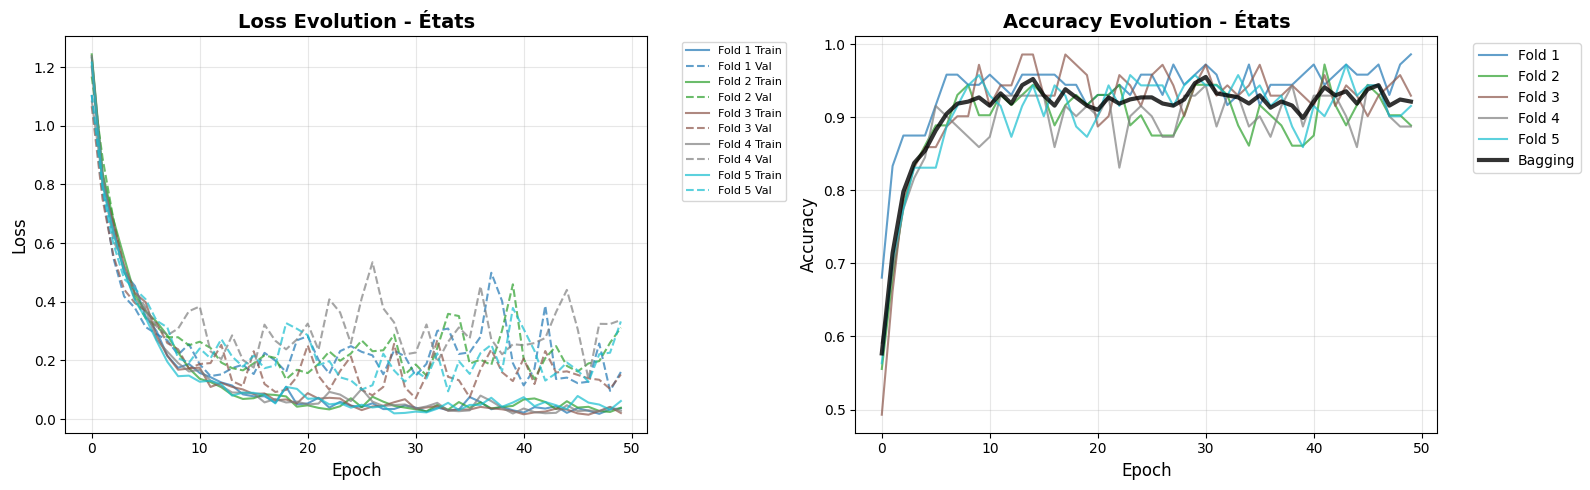

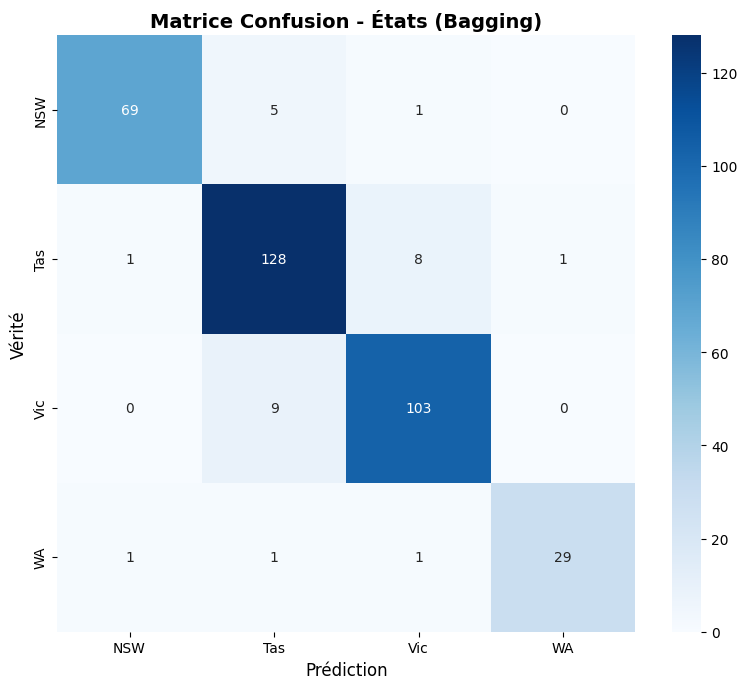

In [6]:
print("="*80)
print("CLASSIFICATION ÉTATS (4 CLASSES) - K-FOLD CV")
print("="*80)

start=time.time()
# Préparation données
state_list = sorted(df['State'].unique())
state_mapping = {state: idx for idx, state in enumerate(state_list)}
df_states = df_combined_unique.copy()
df_states['state_encoded'] = df_unique['State'].map(state_mapping)

image_feature_cols = [col for col in df_combined.columns if col.startswith('img_feature_')]
X = df_states[image_feature_cols].values
y = df_states['state_encoded'].values

# Modèle
class StateClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=4, hidden_dims=[256, 128, 64], dropout=0.3):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.extend([nn.Linear(prev_dim, h), nn.ReLU(), nn.BatchNorm1d(h), nn.Dropout(dropout)])
            prev_dim = h
        layers.append(nn.Linear(prev_dim, num_classes))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# K-Fold CV
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_models = []
fold_train_losses = []
fold_val_losses = []
fold_train_accs = []
fold_val_accs = []
all_val_preds = np.zeros((len(y), len(state_list)))
all_val_labels = np.zeros(len(y), dtype=int)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    print(f"\n--- FOLD {fold}/5 ---")
    
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.FloatTensor(class_weights).to(device)
    
    # DataLoaders
    train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)), 
                              batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val)), 
                            batch_size=32, shuffle=False)
    
    # Entraînement
    model = StateClassifier(input_dim=X.shape[1]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    
    for epoch in range(50):
        # Train
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == batch_y).sum().item()
            total_train += batch_y.size(0)
        
        train_losses.append(train_loss / len(train_loader))
        train_accs.append(correct_train / total_train)
        
        # Validation
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == batch_y).sum().item()
                total_val += batch_y.size(0)
        
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(correct_val / total_val)
    
    # Prédictions finales fold (CORRECTION ICI)
    model.eval()
    idx_counter = 0
    with torch.no_grad():
        for batch_X, _ in val_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            
            batch_size = len(probs)
            all_val_preds[val_idx[idx_counter:idx_counter+batch_size]] = probs
            idx_counter += batch_size
    
    all_val_labels[val_idx] = y_val
    
    fold_preds = np.argmax(all_val_preds[val_idx], axis=1)
    print(f"\nAccuracy: {accuracy_score(y_val, fold_preds):.4f}")
    print(classification_report(y_val, fold_preds, target_names=state_list, zero_division=0))
    
    fold_models.append(model.state_dict())
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accs.append(train_accs)
    fold_val_accs.append(val_accs)

# Bagging predictions
bagging_preds = np.argmax(all_val_preds, axis=1)
bagging_acc_per_epoch = []
for epoch in range(50):
    bagging_acc_per_epoch.append(np.mean([fold_val_accs[i][epoch] for i in range(5)]))

print("\n" + "="*80)
print(f"BAGGING ACCURACY: {accuracy_score(all_val_labels, bagging_preds):.4f}")
print(f"Durée :{(time.time()-start)//1}secondes")
print("="*80)



# Graphiques
colors = plt.cm.tab10(np.linspace(0, 1, 5))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
for i in range(5):
    axes[0].plot(fold_train_losses[i], color=colors[i], linestyle='-', alpha=0.7, label=f'Fold {i+1} Train')
    axes[0].plot(fold_val_losses[i], color=colors[i], linestyle='--', alpha=0.7, label=f'Fold {i+1} Val')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Loss Evolution - États', fontweight='bold', fontsize=14)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(alpha=0.3)

# Accuracy
for i in range(5):
    axes[1].plot(fold_val_accs[i], color=colors[i], linestyle='-', alpha=0.7, label=f'Fold {i+1}')
axes[1].plot(bagging_acc_per_epoch, color='black', linewidth=3, label='Bagging', alpha=0.8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Accuracy Evolution - États', fontweight='bold', fontsize=14)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Matrice confusion bagging
cm = confusion_matrix(all_val_labels, bagging_preds)
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=state_list, yticklabels=state_list)
plt.ylabel('Vérité', fontsize=12)
plt.xlabel('Prédiction', fontsize=12)
plt.title('Matrice Confusion - États (Bagging)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

## MLP Especes

CLASSIFICATION ESPÈCES (15 CLASSES) - K-FOLD CV

--- FOLD 1/5 ---


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



Accuracy: 0.7917
                                                             precision    recall  f1-score   support

                                                     Clover       0.89      1.00      0.94         8
                                                     Fescue       1.00      0.83      0.91         6
                                           Fescue_CrumbWeed       1.00      1.00      1.00         2
                                                    Lucerne       1.00      1.00      1.00         4
                                                      Mixed       0.00      0.00      0.00         1
                                                   Phalaris       1.00      1.00      1.00         1
Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed       1.00      1.00      1.00         2
                                            Phalaris_Clover       0.71      0.56      0.62         9
            Phalaris_Clover_Ryegrass_Barleygrass_Bromegrass       1.00  

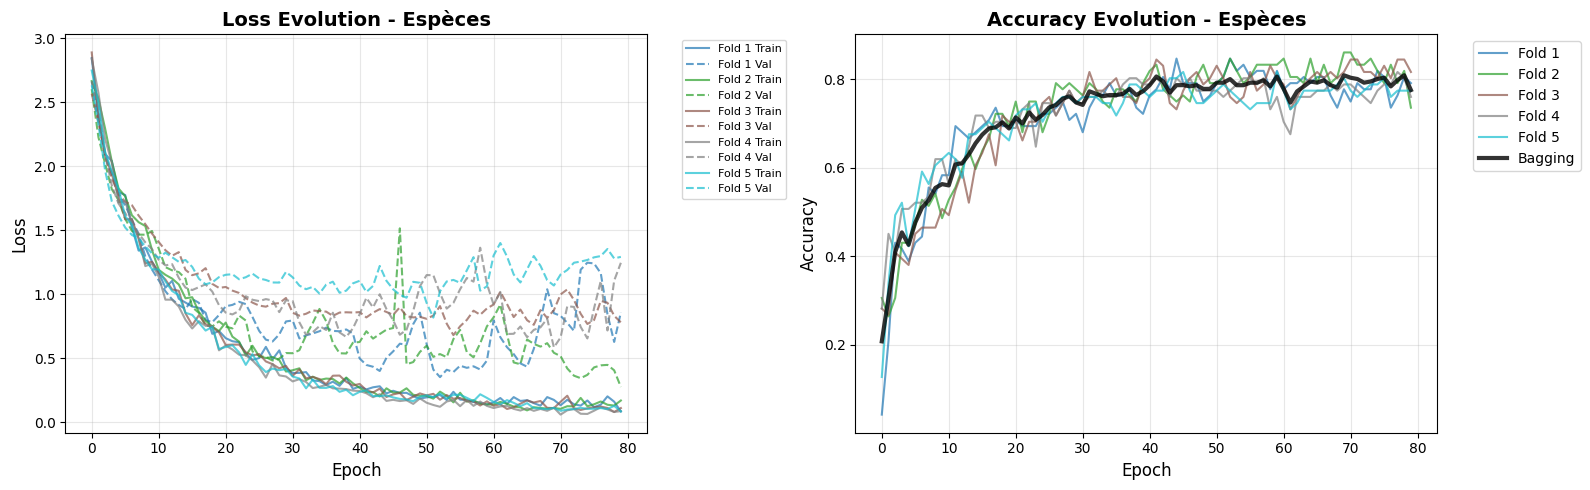

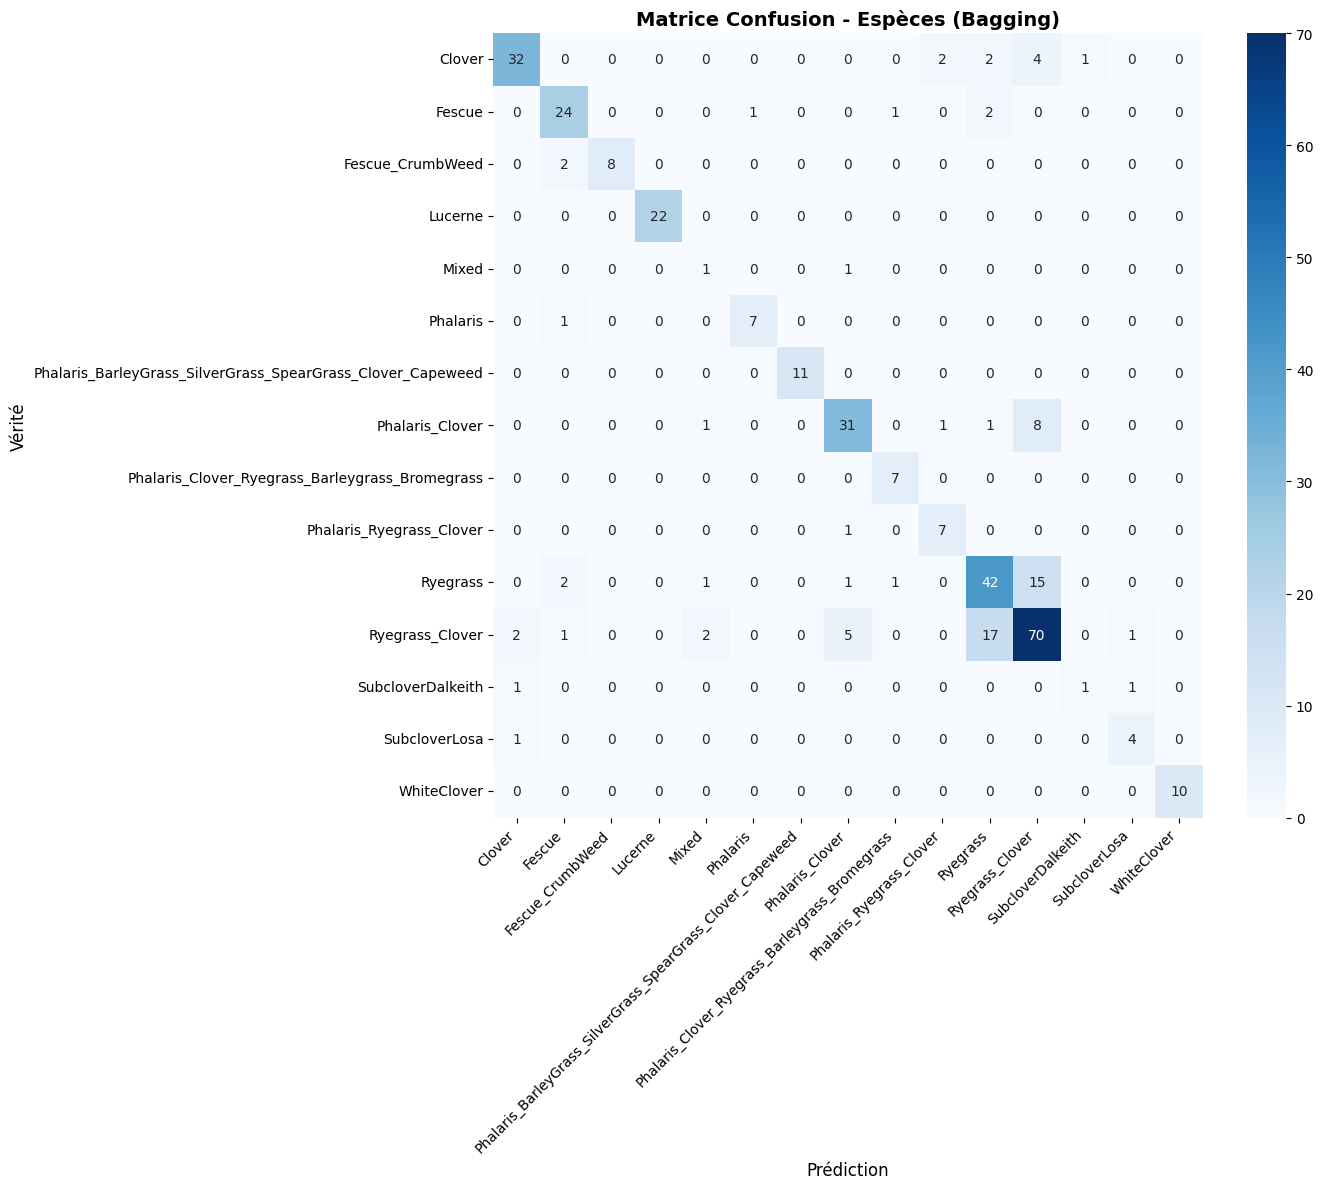

In [7]:

print("="*80)
print("CLASSIFICATION ESPÈCES (15 CLASSES) - K-FOLD CV")
print("="*80)

start=time.time()

# Préparation données
species_list = sorted(df['Species'].unique())
species_mapping = {species: idx for idx, species in enumerate(species_list)}
df_species = df_combined_unique.copy()
df_species['species_encoded'] = df_unique['Species'].map(species_mapping)

image_feature_cols = [col for col in df_combined.columns if col.startswith('img_feature_')]
X = df_species[image_feature_cols].values
y = df_species['species_encoded'].values

# Modèle
class SpeciesClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=15, hidden_dims=[512, 256, 128, 64], dropout=0.4):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.extend([nn.Linear(prev_dim, h), nn.ReLU(), nn.BatchNorm1d(h), nn.Dropout(dropout)])
            prev_dim = h
        layers.append(nn.Linear(prev_dim, num_classes))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# K-Fold CV (même instance que cellule 1)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_models = []
fold_train_losses = []
fold_val_losses = []
fold_train_accs = []
fold_val_accs = []
all_val_preds = np.zeros((len(y), len(species_list)))
all_val_labels = np.zeros(len(y), dtype=int)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    print(f"\n--- FOLD {fold}/5 ---")
    
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.FloatTensor(class_weights).to(device)
    
    # DataLoaders
    train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)), 
                              batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val)), 
                            batch_size=32, shuffle=False)
    
    # Entraînement
    model = SpeciesClassifier(input_dim=X.shape[1]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    
    for epoch in range(80):
        # Train
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == batch_y).sum().item()
            total_train += batch_y.size(0)
        
        train_losses.append(train_loss / len(train_loader))
        train_accs.append(correct_train / total_train)
        
        # Validation
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == batch_y).sum().item()
                total_val += batch_y.size(0)
        
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(correct_val / total_val)
    
    # Prédictions finales fold
    model.eval()
    idx_counter = 0
    with torch.no_grad():
        for batch_X, _ in val_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            
            batch_size = len(probs)
            all_val_preds[val_idx[idx_counter:idx_counter+batch_size]] = probs
            idx_counter += batch_size
    
    all_val_labels[val_idx] = y_val
    
    fold_preds = np.argmax(all_val_preds[val_idx], axis=1)
    print(f"\nAccuracy: {accuracy_score(y_val, fold_preds):.4f}")
    print(classification_report(y_val, fold_preds, 
                                labels=list(range(len(species_list))),
                                target_names=species_list, 
                                zero_division=0))
    
    fold_models.append(model.state_dict())
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accs.append(train_accs)
    fold_val_accs.append(val_accs)

# Bagging predictions
bagging_preds = np.argmax(all_val_preds, axis=1)
bagging_acc_per_epoch = []
for epoch in range(80):
    bagging_acc_per_epoch.append(np.mean([fold_val_accs[i][epoch] for i in range(5)]))

print("\n" + "="*80)
print(f"BAGGING ACCURACY: {accuracy_score(all_val_labels, bagging_preds):.4f}")
print(f"Durée :{(time.time()-start)//1}secondes")
print("="*80)

# Graphiques
colors = plt.cm.tab10(np.linspace(0, 1, 5))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
for i in range(5):
    axes[0].plot(fold_train_losses[i], color=colors[i], linestyle='-', alpha=0.7, label=f'Fold {i+1} Train')
    axes[0].plot(fold_val_losses[i], color=colors[i], linestyle='--', alpha=0.7, label=f'Fold {i+1} Val')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Loss Evolution - Espèces', fontweight='bold', fontsize=14)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(alpha=0.3)

# Accuracy
for i in range(5):
    axes[1].plot(fold_val_accs[i], color=colors[i], linestyle='-', alpha=0.7, label=f'Fold {i+1}')
axes[1].plot(bagging_acc_per_epoch, color='black', linewidth=3, label='Bagging', alpha=0.8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Accuracy Evolution - Espèces', fontweight='bold', fontsize=14)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Matrice confusion bagging
cm = confusion_matrix(all_val_labels, bagging_preds, labels=list(range(len(species_list))))
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=species_list, yticklabels=species_list)
plt.ylabel('Vérité', fontsize=12)
plt.xlabel('Prédiction', fontsize=12)
plt.title('Matrice Confusion - Espèces (Bagging)', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# [4/5] ML model tuning, training and inference prédicting the 5 targets (no taking 5 MLP as input)

## Tuning

In [8]:
# Separate image features and other features
image_feature_cols = [col for col in df_combined.columns if col.startswith('img_feature_')]
other_features_cols = [col for col in df_combined.columns if col.startswith('target_name_')]

X_image_features = df_combined[image_feature_cols]
X_other_features = df_combined[other_features_cols]

# ⚠️ NE PAS FIT ici - on le fera après le split sur les images uniques
print(f"Original number of image features: {X_image_features.shape[1]}")
print(f"Features préparées, split à faire sur image_id unique")

Original number of image features: 768
Features préparées, split à faire sur image_id unique


In [9]:
runned = False

if not runned:
    start = time.time()
    
    # ✅ CORRECTION MAJEURE : Split sur les IMAGE_ID uniques (357 images)
    # Extraire l'image_id depuis sample_id (format: ID1011485656__Dry_Clover_g)
    df_combined['image_id'] = df_combined['sample_id'].str.split('__').str[0]
    
    unique_image_ids = df_combined['image_id'].unique()
    print(f"Nombre d'images uniques: {len(unique_image_ids)}")
    
    # Split sur les images, pas sur les lignes !
    train_ids, test_ids = train_test_split(unique_image_ids, test_size=0.2, random_state=42)
    
    # Créer les masks pour train/test
    train_mask = df_combined['image_id'].isin(train_ids)
    test_mask = df_combined['image_id'].isin(test_ids)
    
    # Séparer les données
    X_image_train = X_image_features[train_mask]
    X_image_test = X_image_features[test_mask]
    X_other_train = X_other_features[train_mask]
    X_other_test = X_other_features[test_mask]
    y_train = df_combined[train_mask]['target']
    y_test = df_combined[test_mask]['target']
    
    print(f"Train: {len(train_ids)} images ({len(y_train)} lignes)")
    print(f"Test: {len(test_ids)} images ({len(y_test)} lignes)")
    
    # ✅ FIT Scaler UNIQUEMENT sur train
    scaler = StandardScaler()
    X_image_train_scaled = scaler.fit_transform(X_image_train)
    X_image_test_scaled = scaler.transform(X_image_test)  # Transform only!
    
    # ✅ FIT PCA UNIQUEMENT sur train
    pca = PCA(n_components=75)
    X_image_train_pca = pca.fit_transform(X_image_train_scaled)
    X_image_test_pca = pca.transform(X_image_test_scaled)  # Transform only!
    
    # Convertir en DataFrames
    X_train_pca_df = pd.DataFrame(
        X_image_train_pca,
        index=X_image_train.index,
        columns=[f'pca_img_feature_{i}' for i in range(75)]
    )
    X_test_pca_df = pd.DataFrame(
        X_image_test_pca,
        index=X_image_test.index,
        columns=[f'pca_img_feature_{i}' for i in range(75)]
    )
    
    # Combiner avec les other_features
    X_train = pd.concat([X_other_train.reset_index(drop=True), 
                         X_train_pca_df.reset_index(drop=True)], axis=1)
    X_test = pd.concat([X_other_test.reset_index(drop=True), 
                        X_test_pca_df.reset_index(drop=True)], axis=1)
    
    # Reset index pour y aussi
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    print(f"\nFormes finales:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    # Bayesian optimization
    search_spaces = {
        'n_estimators': Integer(100, 1000),
        'learning_rate': Real(0.001, 0.2, prior='log-uniform'),
        'max_depth': Integer(3, 10),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_alpha': Real(1e-8, 10, prior='log-uniform'),
        'reg_lambda': Real(1, 10),
        'subsample': Real(0.5, 1.0),
    }
    
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    
    bayes_search = BayesSearchCV(
        estimator=xgb_model,
        search_spaces=search_spaces,
        n_iter=3,
        scoring='neg_mean_squared_error',
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs=-1,
    )
    
    bayes_search.fit(X_train, y_train)
    
    best_params = bayes_search.best_params_
    xgb_model = bayes_search.best_estimator_
    
    stop = time.time()
    print(f"\nBayesian optimization complete in {(stop-start)/60:.1f} minutes")
    print(f"Best parameters: {best_params}")

Nombre d'images uniques: 357
Train: 285 images (1425 lignes)
Test: 72 images (360 lignes)

Formes finales:
X_train: (1425, 80), y_train: (1425,)
X_test: (360, 80), y_test: (360,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Bayesian optimization complete in 0.9 minutes
Best parameters: OrderedDict({'colsample_bytree': 0.705051979426657, 'learning_rate': 0.047262725629040714, 'max_depth': 10, 'n_estimators': 384, 'reg_alpha': 0.010748095940707632, 'reg_lambda': 4.727067692369847, 'subsample': 0.675465667449572})


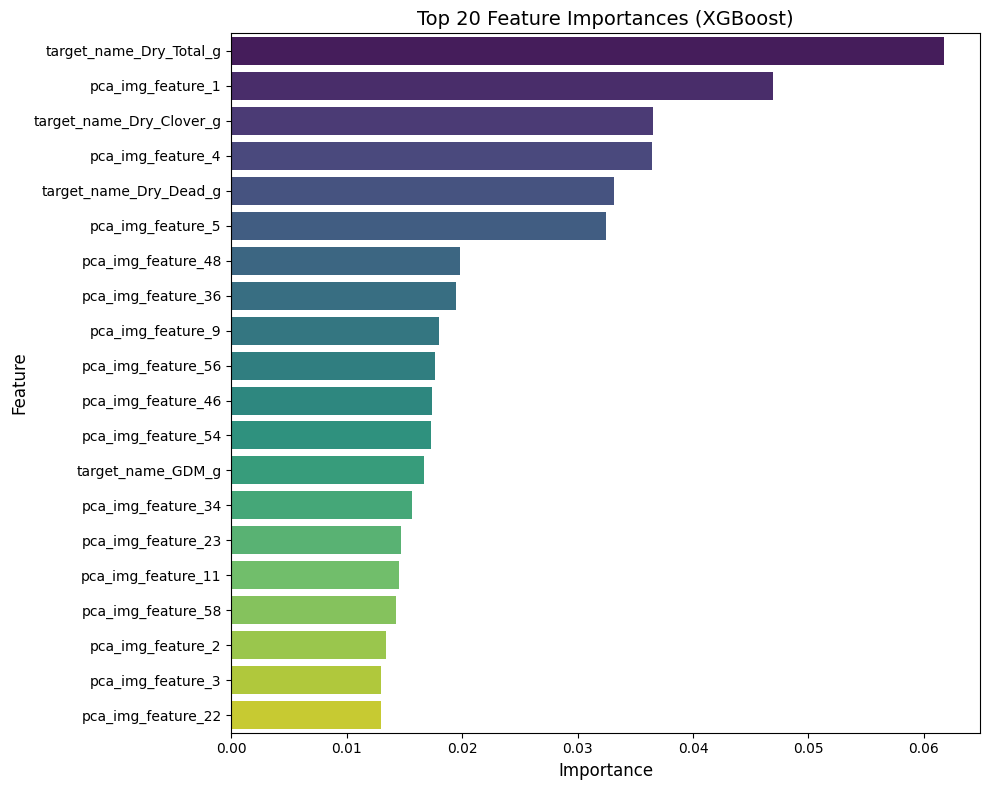

Sorted Feature Importances:


target_name_Dry_Total_g     0.061786
pca_img_feature_1           0.046957
target_name_Dry_Clover_g    0.036577
pca_img_feature_4           0.036450
target_name_Dry_Dead_g      0.033199
                              ...   
pca_img_feature_27          0.006176
pca_img_feature_35          0.006042
pca_img_feature_38          0.005978
pca_img_feature_52          0.004989
pca_img_feature_0           0.003220
Length: 80, dtype: float32

In [13]:

# Get feature importances from the best model found by GridSearchCV
# If you didn't use GridSearchCV, use xgb_model.feature_importances_
feature_importances = xgb_model.feature_importances_

# Create a pandas Series for easier handling and sorting
feature_importances_series = pd.Series(feature_importances, index=X_train.columns)

# Sort features by importance
sorted_feature_importances = feature_importances_series.sort_values(ascending=False)

# Plot the top N feature importances (e.g., top 20)
n_top_features = 20
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_feature_importances.head(n_top_features).values,
            y=sorted_feature_importances.head(n_top_features).index,
            palette='viridis')
plt.title(f'Top {n_top_features} Feature Importances (XGBoost)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# You can also display the sorted feature importances
print("Sorted Feature Importances:")
display(sorted_feature_importances)

## Overfit analysis

ANALYSE DE L'OVERFIT - XGBOOST

Metric          Train           Test            Gap            
------------------------------------------------------------
MAE             0.4490          8.4042          7.9552         
RMSE            0.9343          12.6194         11.6852        
R²              0.9988          0.7034          0.2953         

Target               Train R²        Test R²         Gap            
-----------------------------------------------------------------
Dry_Clover_g         0.9913          0.4108          0.5806         
Dry_Dead_g           0.9940          0.3155          0.6785         
Dry_Green_g          0.9985          0.6401          0.3584         
Dry_Total_g          0.9991          0.5723          0.4268         
GDM_g                0.9993          0.6383          0.3610         


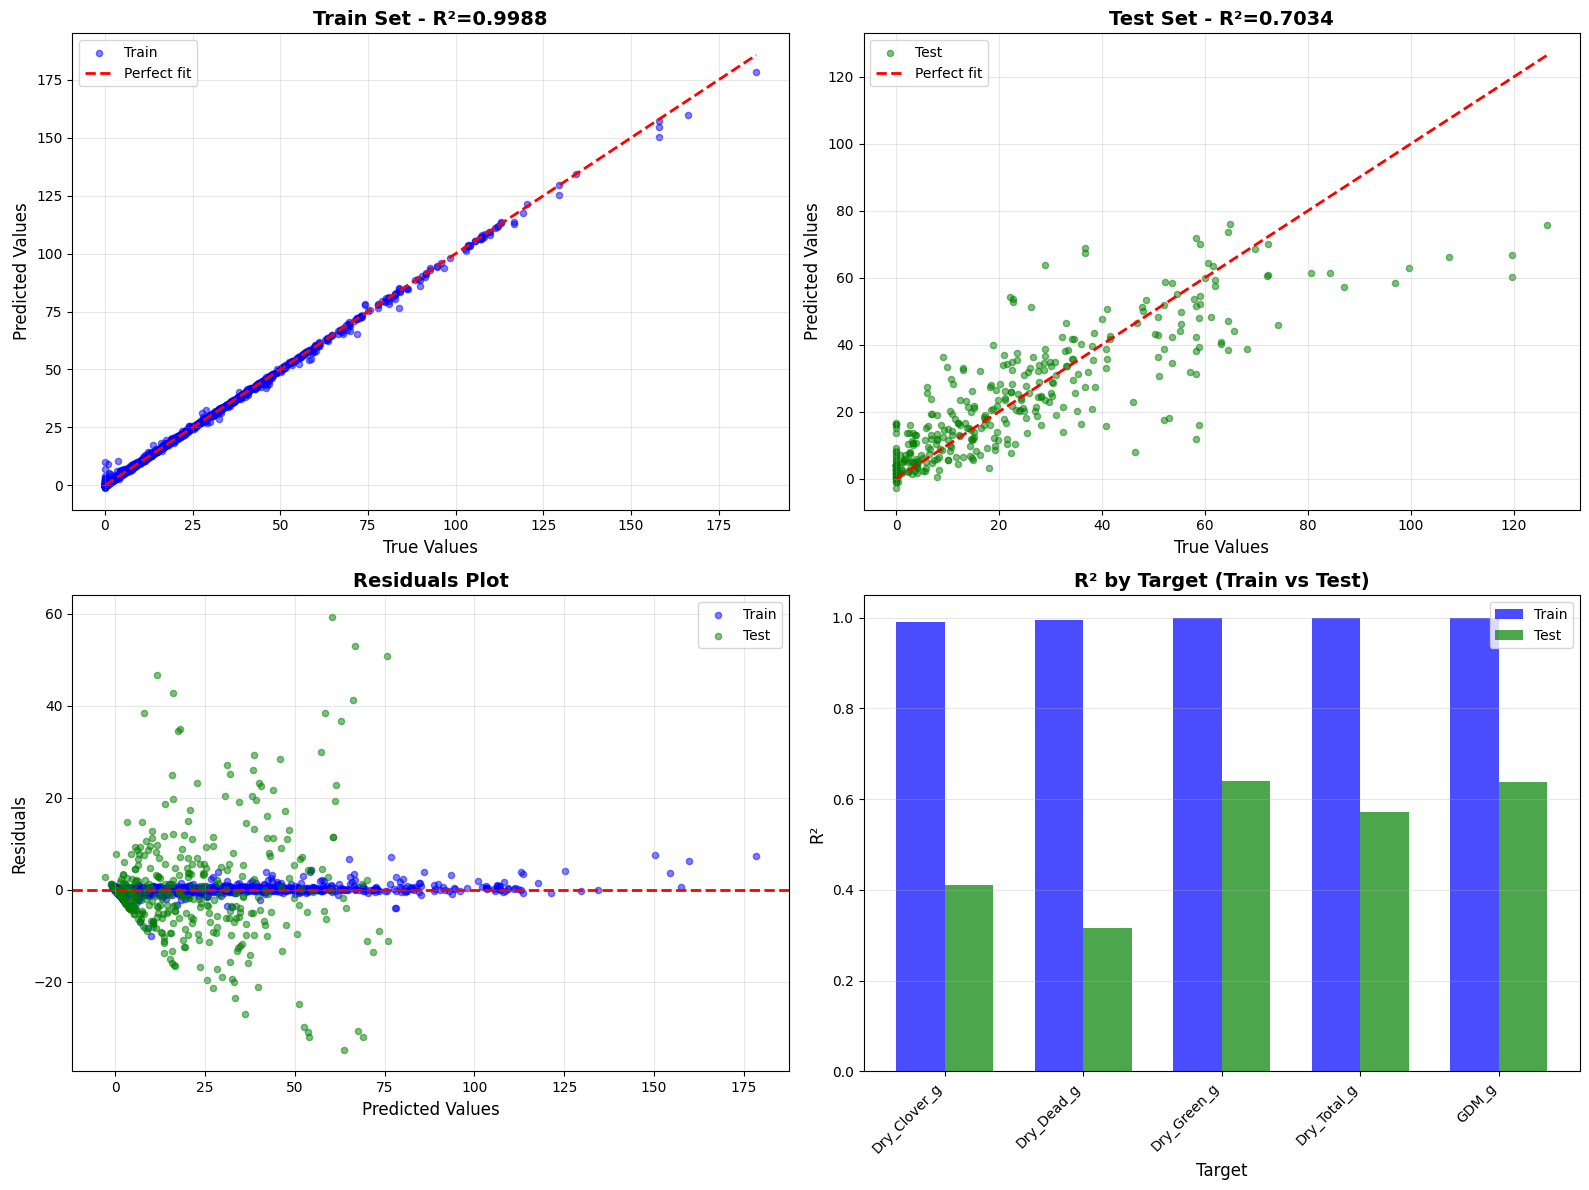

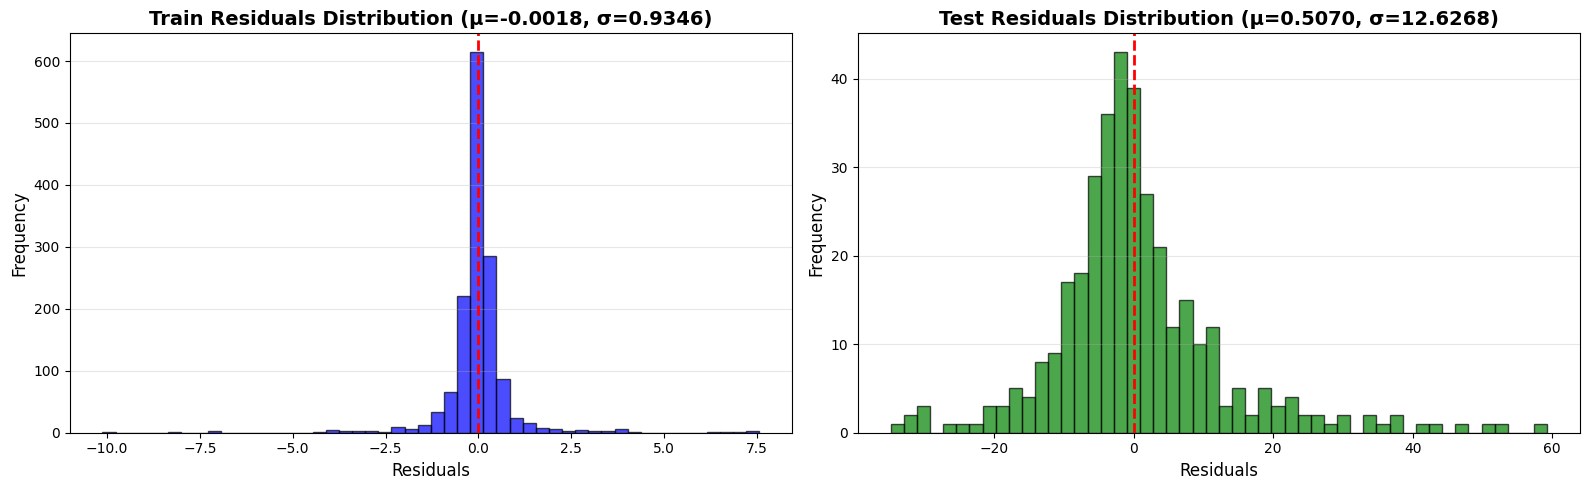


DIAGNOSTIC D'OVERFIT
⚠️  OVERFIT SÉVÈRE détecté (Gap R² > 0.15)

Gap R² = 0.2953
Gap MAE = 7.9552
Gap RMSE = 11.6852

Recommandations:
  - Augmenter reg_alpha et reg_lambda
  - Réduire max_depth
  - Augmenter subsample (< 0.8)
  - Considérer early stopping plus agressif
[CV] END colsample_bytree=0.705051979426657, learning_rate=0.047262725629040714, max_depth=10, n_estimators=384, reg_alpha=0.010748095940707632, reg_lambda=4.727067692369847, subsample=0.675465667449572; total time=  15.8s
[CV] END colsample_bytree=0.9186941777766422, learning_rate=0.10777919831150796, max_depth=5, n_estimators=956, reg_alpha=0.5986200228570064, reg_lambda=1.5608164675966432, subsample=0.5691542691392876; total time=  14.1s
[CV] END colsample_bytree=0.705051979426657, learning_rate=0.047262725629040714, max_depth=10, n_estimators=384, reg_alpha=0.010748095940707632, reg_lambda=4.727067692369847, subsample=0.675465667449572; total time=  19.3s
[CV] END colsample_bytree=0.9186941777766422, learning_rate=

In [16]:
# ===============================================================================
# ANALYSE DE L'OVERFIT - XGBOOST
# ===============================================================================

print("="*80)
print("ANALYSE DE L'OVERFIT - XGBOOST")
print("="*80)

# Prédictions sur train et test
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Métriques globales
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\n{'Metric':<15} {'Train':<15} {'Test':<15} {'Gap':<15}")
print("-"*60)
print(f"{'MAE':<15} {train_mae:<15.4f} {test_mae:<15.4f} {test_mae-train_mae:<15.4f}")
print(f"{'RMSE':<15} {train_rmse:<15.4f} {test_rmse:<15.4f} {test_rmse-train_rmse:<15.4f}")
print(f"{'R²':<15} {train_r2:<15.4f} {test_r2:<15.4f} {train_r2-test_r2:<15.4f}")

# Analyse par target
target_names_train = df_combined[train_mask]['target_name'].reset_index(drop=True)
target_names_test = df_combined[test_mask]['target_name'].reset_index(drop=True)

print(f"\n{'Target':<20} {'Train R²':<15} {'Test R²':<15} {'Gap':<15}")
print("-"*65)

results_by_target = []
for target in sorted(df_combined['target_name'].unique()):
    # Train metrics
    mask_train = target_names_train == target
    if mask_train.sum() > 0:
        train_r2_target = r2_score(y_train[mask_train], y_train_pred[mask_train])
    else:
        train_r2_target = np.nan
    
    # Test metrics
    mask_test = target_names_test == target
    if mask_test.sum() > 0:
        test_r2_target = r2_score(y_test[mask_test], y_test_pred[mask_test])
    else:
        test_r2_target = np.nan
    
    gap = train_r2_target - test_r2_target if not np.isnan(train_r2_target) and not np.isnan(test_r2_target) else np.nan
    
    print(f"{target:<20} {train_r2_target:<15.4f} {test_r2_target:<15.4f} {gap:<15.4f}")
    results_by_target.append({
        'target': target,
        'train_r2': train_r2_target,
        'test_r2': test_r2_target,
        'gap': gap
    })

# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Prédictions vs Vraies valeurs (Train)
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.5, s=20, color='blue', label='Train')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
                'r--', lw=2, label='Perfect fit')
axes[0, 0].set_xlabel('True Values', fontsize=12)
axes[0, 0].set_ylabel('Predicted Values', fontsize=12)
axes[0, 0].set_title(f'Train Set - R²={train_r2:.4f}', fontweight='bold', fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Prédictions vs Vraies valeurs (Test)
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.5, s=20, color='green', label='Test')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect fit')
axes[0, 1].set_xlabel('True Values', fontsize=12)
axes[0, 1].set_ylabel('Predicted Values', fontsize=12)
axes[0, 1].set_title(f'Test Set - R²={test_r2:.4f}', fontweight='bold', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Résidus (Train vs Test)
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

axes[1, 0].scatter(y_train_pred, residuals_train, alpha=0.5, s=20, color='blue', label='Train')
axes[1, 0].scatter(y_test_pred, residuals_test, alpha=0.5, s=20, color='green', label='Test')
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Values', fontsize=12)
axes[1, 0].set_ylabel('Residuals', fontsize=12)
axes[1, 0].set_title('Residuals Plot', fontweight='bold', fontsize=14)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. R² par target (Train vs Test)
df_results = pd.DataFrame(results_by_target)
x_pos = np.arange(len(df_results))
width = 0.35

axes[1, 1].bar(x_pos - width/2, df_results['train_r2'], width, 
               label='Train', color='blue', alpha=0.7)
axes[1, 1].bar(x_pos + width/2, df_results['test_r2'], width, 
               label='Test', color='green', alpha=0.7)
axes[1, 1].set_xlabel('Target', fontsize=12)
axes[1, 1].set_ylabel('R²', fontsize=12)
axes[1, 1].set_title('R² by Target (Train vs Test)', fontweight='bold', fontsize=14)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(df_results['target'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Distribution des résidus
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(residuals_train, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Residuals', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title(f'Train Residuals Distribution (μ={residuals_train.mean():.4f}, σ={residuals_train.std():.4f})', 
                  fontweight='bold', fontsize=14)
axes[0].grid(alpha=0.3, axis='y')

axes[1].hist(residuals_test, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Residuals', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'Test Residuals Distribution (μ={residuals_test.mean():.4f}, σ={residuals_test.std():.4f})', 
                  fontweight='bold', fontsize=14)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Diagnostic d'overfit
print("\n" + "="*80)
print("DIAGNOSTIC D'OVERFIT")
print("="*80)

r2_gap = train_r2 - test_r2
mae_gap = test_mae - train_mae
rmse_gap = test_rmse - train_rmse

if r2_gap > 0.15:
    print("⚠️  OVERFIT SÉVÈRE détecté (Gap R² > 0.15)")
elif r2_gap > 0.08:
    print("⚠️  OVERFIT MODÉRÉ détecté (Gap R² > 0.08)")
elif r2_gap > 0.03:
    print("✓  OVERFIT LÉGER (Gap R² > 0.03) - acceptable")
else:
    print("✓  PAS D'OVERFIT significatif - modèle bien généralisé")

print(f"\nGap R² = {r2_gap:.4f}")
print(f"Gap MAE = {mae_gap:.4f}")
print(f"Gap RMSE = {rmse_gap:.4f}")

print("\nRecommandations:")
if r2_gap > 0.15:
    print("  - Augmenter reg_alpha et reg_lambda")
    print("  - Réduire max_depth")
    print("  - Augmenter subsample (< 0.8)")
    print("  - Considérer early stopping plus agressif")
elif r2_gap > 0.08:
    print("  - Ajuster légèrement reg_alpha/reg_lambda")
    print("  - Vérifier max_depth et subsample")
else:
    print("  - Paramètres actuels appropriés")
    print("  - Peut tenter d'augmenter la complexité pour améliorer les performances")

print("="*80)